<B>For a given time period averages rates between a source and a destination and plots it.</B>

In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
from elasticsearch import Elasticsearch, exceptions as es_exceptions
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

currentTime=int(round(datetime.utcnow().timestamp()* 1000))
lastHours=96
startTime=currentTime - lastHours*3600000 
endTime=currentTime

source='WT2'
destination='MWT2'

In [2]:
es = Elasticsearch([{'host':'192.170.227.90', 'port':9200}])

In [3]:
#constants
#queryString='source:'+source+' AND destination:' + destination
searchString={
    "size":0,
    "query":{
        "filtered":{
            "query":{
                "bool" : {
                  "must" :     [ 
                        {"term": {"source": { "value": source } } },
                        {"term": {"destination": { "value": destination } } }
                    ]
                }
#               "query_string":{"query":queryString,"analyze_wildcard":True,"lowercase_expanded_terms":False}
            },
            "filter":{
                "range":{"timestamp":{"gte": startTime,"lte": endTime,"format": "epoch_millis"}}
            }
        }
    },
    "aggs": {
        "2": {
          "date_histogram": {
            "field": "timestamp",
            "interval": "10m",
            "time_zone": "America/Chicago",
            "min_doc_count": 1
          },
          "aggs": { "1": { "avg": { "field": "rate" }}}}} 
}

Actually running the search

In [4]:
res= es.search(body=searchString)
print ('results returned in:',res['took'], 'ms')
print ('results:', res['hits']['total'])
r=res['aggregations']['2']['buckets']
# print (r)
AllData=[]
dates=[]
rates=[]
for s in r:
    #print ('result:', s['key'], s["1"]["value"])
    AllData.append([s['key'],s["1"]["value"]])
    dates.append(datetime.fromtimestamp(s['key']/1000))
    rates.append(s["1"]["value"])
    
data=np.array( AllData )

results returned in: 669 ms
results: 257


plotting results

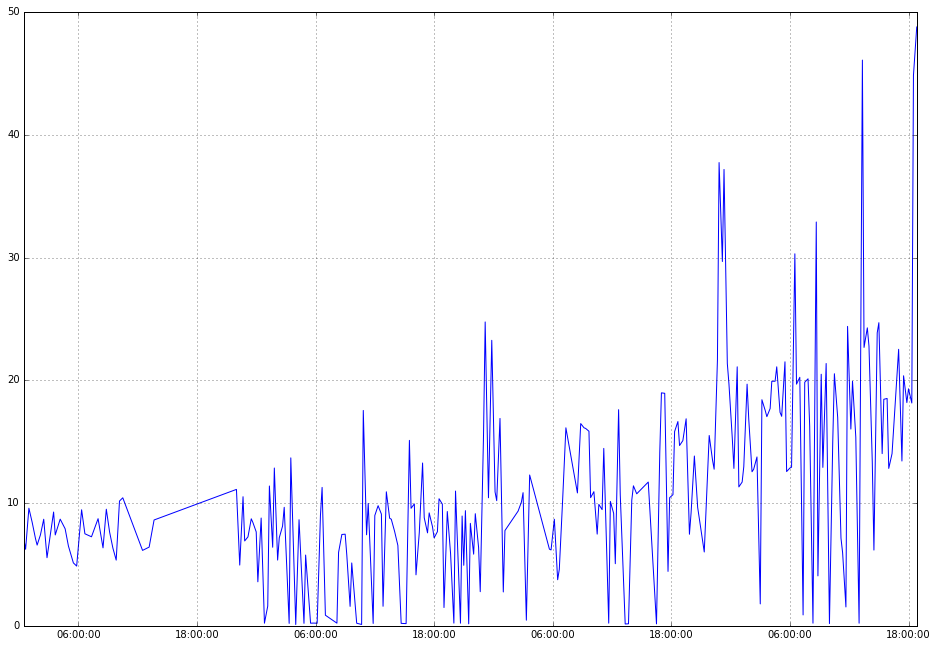

In [5]:
fig, ax = plt.subplots()
rateplot = ax.plot_date(dates, rates, '-')

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)

# Format
fig = plt.gcf()
fig.set_size_inches(16, 11)

ax.grid(True)
# ax.autoscale_view()

# fig.autofmt_xdate()

